In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

In [33]:
# Cargar datos
filepath = 'C:/Users/winte/OneDrive/Desktop/project-bolt-sb1-rudbqzwl (2)/MyoDataset.csv'
df = pd.read_csv(filepath)

df = df.iloc[:, :9]  # Solo tomar los 8 sensores y la etiqueta

In [34]:
# Separar datos de entrada (X) y salida (y)
X = df.iloc[:, :-1].values  # Entradas (8 sensores EMG)
y = df.iloc[:, -1].values  # Etiquetas
y = to_categorical(y, num_classes=6)  # Convertir etiquetas a one-hot


In [35]:
print(df['Output'].value_counts())

Output
0    498
2    498
1    497
3    497
4    497
5    497
Name: count, dtype: int64


In [36]:
# Normalizar los datos de entrada entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.array([[0] * 8, [1023] * 8]))  # Ajuste basado en Myo
X_normalized = scaler.transform(X)

In [37]:
# Reformatear los datos para LSTM (ventanas de tiempo)
SECUENCIA_LONGITUD = 100  # Número de frames por ventana
X_seq = []
y_seq = []

# Crear ventanas de secuencias
for i in range(len(X_normalized) - SECUENCIA_LONGITUD):
    X_seq.append(X_normalized[i:i+SECUENCIA_LONGITUD])  # Secuencia de 10 frames
    y_seq.append(y[i+SECUENCIA_LONGITUD])  # Etiqueta asociada al último frame

X_seq = np.array(X_seq)  # Convertir a numpy array
y_seq = np.array(y_seq)

In [38]:
# Dividir en entrenamiento y prueba (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [39]:
print(X_train.shape)
print(y_train.shape)

(2307, 100, 8)
(2307, 6)


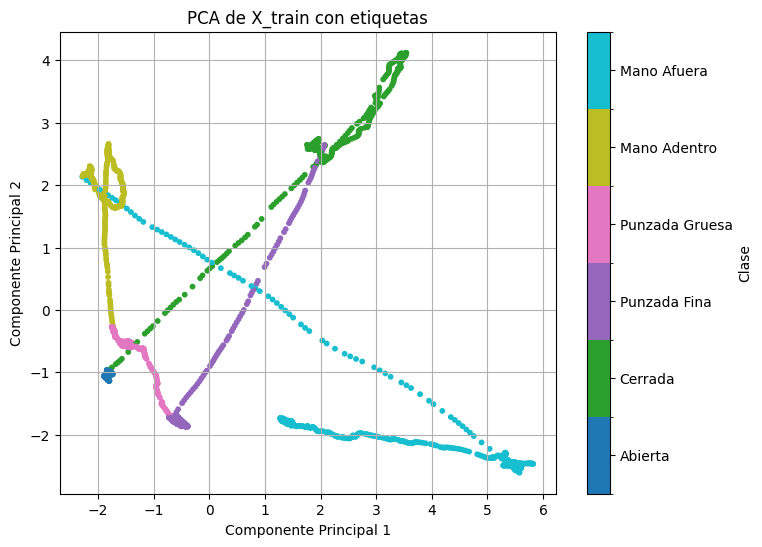

[0 1 2 3 4 5]


In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

y_labels = np.argmax(y_train, axis=1)

pca = PCA(n_components=2)

X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_train_pca = pca.fit_transform(X_train_2d)

# Mapa de colores con 4 clases
cmap = plt.get_cmap('tab10', 6)
norm = mcolors.BoundaryNorm(np.arange(7) - 0.5, 6)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_labels, cmap=cmap, norm=norm, s=10)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA de X_train con etiquetas')

cbar = plt.colorbar(scatter, ticks=[0, 1, 2, 3, 4, 5])
class_names = ['Abierta', 'Cerrada', 'Punzada Fina', 'Punzada Gruesa', 'Mano Adentro', 'Mano Afuera']
cbar.set_ticks([0, 1, 2, 3, 4, 5])
cbar.set_ticklabels(class_names)
cbar.set_label('Clase')
plt.grid(True)
plt.show()


print(np.unique(y_labels))


In [41]:
import numpy as np

def add_gaussian_noise(data, mean=0, std=0.05):
    """
    Agrega ruido gaussiano a los datos EMG.
    """
    noise = np.random.normal(mean, std, data.shape)
    return data + noise

def apply_jitter(data, jitter_strength=0.05):
    """
    Aplica un desplazamiento aleatorio a la señal.
    """
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=data.shape)
    return data + jitter

def scale_signal(data, scale_min=0.8, scale_max=1.2):
    """
    Aplica un factor de escala aleatorio a los datos.
    """
    scale_factor = np.random.uniform(scale_min, scale_max)
    return data * scale_factor

def time_warping(data, sigma=0.2):
    """
    Simula pequeñas deformaciones temporales en la señal EMG.
    sigma: Controla la cantidad de deformación aplicada.
    """
    # Crear una transformación aleatoria de los índices temporales
    indices = np.arange(len(data))
    new_indices = indices + np.random.normal(0, sigma, size=len(indices))
    new_indices = np.clip(new_indices, 0, len(data) - 1)  # Evitar valores fuera del rango

    # Si `data` es 2D (Ej: `(100, 8)`), aplicamos `np.interp()` a cada columna
    if data.ndim == 2:
        warped_data = np.zeros_like(data)
        for i in range(data.shape[1]):  # Iteramos por cada canal EMG
            warped_data[:, i] = np.interp(indices, new_indices, np.interp(new_indices, indices, data[:, i]))
        return warped_data
    else:
        return np.interp(indices, new_indices, np.interp(new_indices, indices, data))
    
def permute_segments(data, n_segments=4):
    """
    Divide la señal en segmentos y los reordena aleatoriamente.
    """
    segment_length = data.shape[0] // n_segments
    segments = [data[i*segment_length:(i+1)*segment_length] for i in range(n_segments)]
    np.random.shuffle(segments)
    return np.concatenate(segments, axis=0)

def partial_flip(data, flip_ratio=0.3):
    """
    Invierte aleatoriamente una porción de la señal en el tiempo.
    """
    length = data.shape[0]
    flip_size = int(length * flip_ratio)
    start = np.random.randint(0, length - flip_size)
    flipped = data.copy()
    flipped[start:start+flip_size] = flipped[start:start+flip_size][::-1]
    return flipped

def temporal_dropout(data, drop_prob=0.1):
    """
    Elimina aleatoriamente algunos puntos temporales (los reemplaza por 0).
    """
    mask = np.random.rand(*data.shape) > drop_prob
    return data * mask

def augment_specific_classes(X, y_labels, target_classes=[2, 3], times_per_sample=1, num_classes=6):

    """
    Aplica data augmentation solo a las clases especificadas.
    
    Parámetros:
    - X: np.array de forma (N, 100, 8)
    - y_labels: array plano de clases (shape: N,)
    - target_classes: lista con clases objetivo (por defecto: [2, 3])
    - times_per_sample: cuántas veces aumentar cada muestra objetivo
    - num_classes: total de clases para codificación one-hot
    
    Retorna:
    - X_final, y_final: datos originales + aumentados
    """
    X_aug = []
    y_aug = []

    for x, y in zip(X, y_labels):
        if y in target_classes:
            for _ in range(times_per_sample):
                x_aug = augment_data(x)
                X_aug.append(x_aug)
                y_aug.append(y)

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    y_aug_onehot = tf.keras.utils.to_categorical(y_aug, num_classes=num_classes)

    # Codifica los originales si es necesario
    y_orig_onehot = tf.keras.utils.to_categorical(y_labels, num_classes=num_classes)

    X_final = np.concatenate([X, X_aug], axis=0)
    y_final = np.concatenate([y_orig_onehot, y_aug_onehot], axis=0)

    return X_final, y_final, X_aug, y_aug_onehot


def augment_data(data):
    if np.random.rand() < 0.8:
        data = add_gaussian_noise(data, std=0.05)
    if np.random.rand() < 0.6:
        data = apply_jitter(data, jitter_strength=0.05)
    if np.random.rand() < 0.6:
        data = scale_signal(data)
    if np.random.rand() < 0.5:
        data = time_warping(data)
    if np.random.rand() < 0.4:
        data = permute_segments(data)
    if np.random.rand() < 0.3:
        data = partial_flip(data)
    if np.random.rand() < 0.2:
        data = temporal_dropout(data)
    return data




In [42]:
X_train_l = np.array([augment_data(x) for x in X_train])
X_train_final, y_train_final, X_train_augmented, y_train_augmented = augment_specific_classes(X_train_l, y_labels, target_classes=[0,2, 3])



In [43]:
print(X_train_final.shape)
print(y_train_final.shape)

(3430, 100, 8)
(3430, 6)


C:\Users\winte\AppData\Local\Temp\ipykernel_7484\2576188125.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


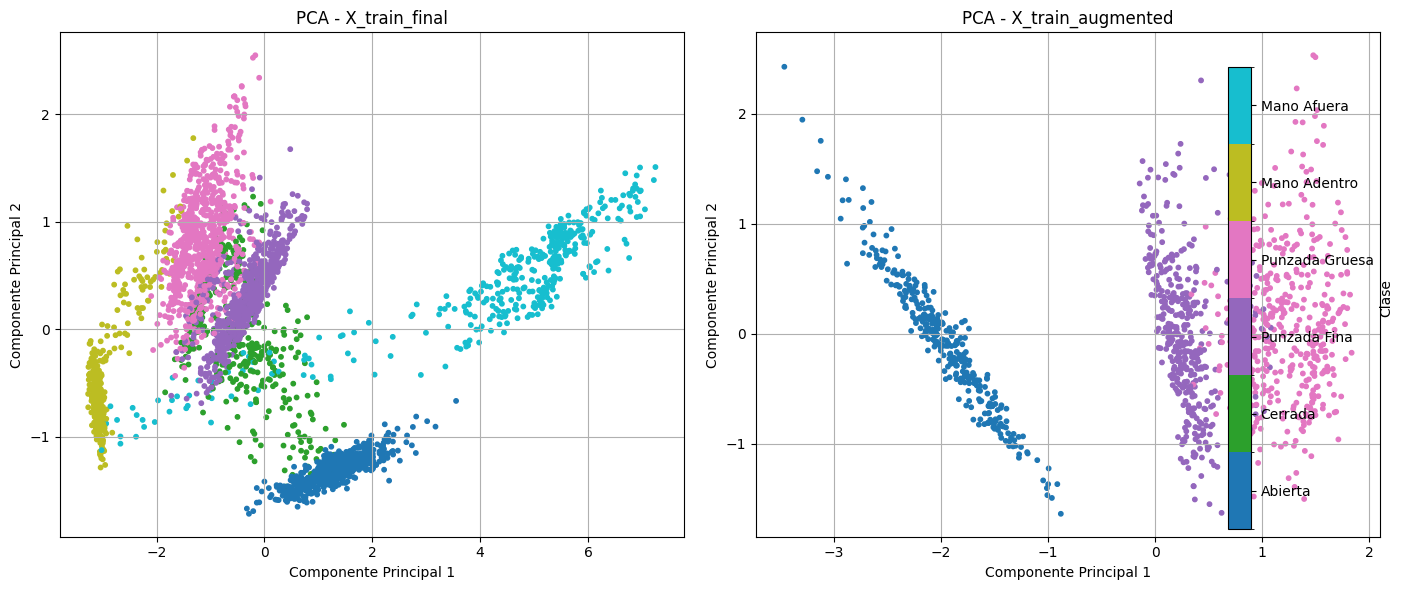

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Mapa de colores
cmap = plt.get_cmap('tab10', 6)
norm = mcolors.BoundaryNorm(np.arange(7) - 0.5, 6)
class_names = ['Abierta', 'Cerrada', 'Punzada Fina', 'Punzada Gruesa', 'Mano Adentro', 'Mano Afuera']

# PCA para X_train_final
pca_f = PCA(n_components=2)
X_train_final_2d = X_train_final.reshape(X_train_final.shape[0], -1)
X_train_pca_f = pca_f.fit_transform(X_train_final_2d)
y_labelsf = np.argmax(y_train_final, axis=1)

# PCA para X_train_augmented
pca_a = PCA(n_components=2)
X_train_augmented_2d = X_train_augmented.reshape(X_train_augmented.shape[0], -1)
X_train_pca_a = pca_a.fit_transform(X_train_augmented_2d)
y_labelsa = np.argmax(y_train_augmented, axis=1)

# Gráficas lado a lado
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Gráfica 1 - Final
sc_f = axs[0].scatter(X_train_pca_f[:, 0], X_train_pca_f[:, 1], c=y_labelsf, cmap=cmap, norm=norm, s=10)
axs[0].set_title('PCA - X_train_final')
axs[0].set_xlabel('Componente Principal 1')
axs[0].set_ylabel('Componente Principal 2')
axs[0].grid(True)

# Gráfica 2 - Solo Augmented
sc_a = axs[1].scatter(X_train_pca_a[:, 0], X_train_pca_a[:, 1], c=y_labelsa, cmap=cmap, norm=norm, s=10)
axs[1].set_title('PCA - X_train_augmented')
axs[1].set_xlabel('Componente Principal 1')
axs[1].set_ylabel('Componente Principal 2')
axs[1].grid(True)

# Barra de color compartida
cbar = fig.colorbar(sc_f, ax=axs, ticks=range(6), orientation='vertical', fraction=0.025)
cbar.set_ticklabels(class_names)
cbar.set_label('Clase')

plt.tight_layout()
plt.show()


C:\Users\winte\AppData\Local\Temp\ipykernel_28468\867139892.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


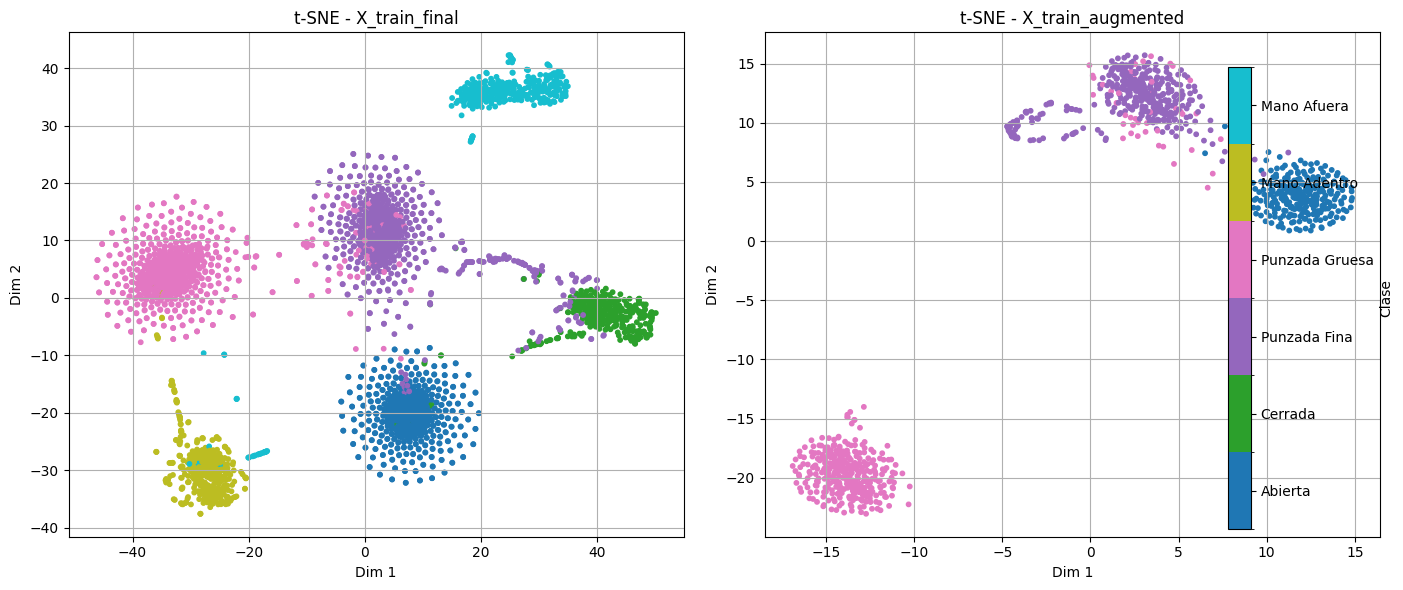

In [44]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Colores y nombres
cmap = plt.get_cmap('tab10', 6)
norm = mcolors.BoundaryNorm(np.arange(7) - 0.5, 6)
class_names = ['Abierta', 'Cerrada', 'Punzada Fina', 'Punzada Gruesa', 'Mano Adentro', 'Mano Afuera']

# Datos planos
X_f_2d = X_train_final.reshape(X_train_final.shape[0], -1)
X_a_2d = X_train_augmented.reshape(X_train_augmented.shape[0], -1)
y_labelsf = np.argmax(y_train_final, axis=1)
y_labelsa = np.argmax(y_train_augmented, axis=1)

# t-SNE para f
tsne_f = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne_f = tsne_f.fit_transform(X_f_2d)

# t-SNE para a
tsne_a = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne_a = tsne_a.fit_transform(X_a_2d)

# Graficar lado a lado
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# t-SNE - Final
sc_f = axs[0].scatter(X_tsne_f[:, 0], X_tsne_f[:, 1], c=y_labelsf, cmap=cmap, norm=norm, s=10)
axs[0].set_title('t-SNE - X_train_final')
axs[0].set_xlabel('Dim 1')
axs[0].set_ylabel('Dim 2')
axs[0].grid(True)

# t-SNE - Augmented
sc_a = axs[1].scatter(X_tsne_a[:, 0], X_tsne_a[:, 1], c=y_labelsa, cmap=cmap, norm=norm, s=10)
axs[1].set_title('t-SNE - X_train_augmented')
axs[1].set_xlabel('Dim 1')
axs[1].set_ylabel('Dim 2')
axs[1].grid(True)

# Barra de color compartida
cbar = fig.colorbar(sc_f, ax=axs, ticks=range(6), fraction=0.025)
cbar.set_ticklabels(class_names)
cbar.set_label('Clase')

plt.tight_layout()
plt.show()


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(100, 8), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),

    GlobalAveragePooling1D(),

    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(6, activation='softmax')
])


c:\Users\winte\anaconda3\envs\my_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Agregar Early Stopping para detener entrenamiento si el modelo empieza a sobreajustar

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
checkpoint = ModelCheckpoint(
    filepath='C:/Users/protesis/myoarm/RepoPyoMyo/pyomyo/DatasetExtractV2/modelo_LSTM.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False
)

callbacks = [early_stopping, reduce_lr, checkpoint]


In [47]:
# Entrenar el modelo
history = model.fit(X_train_final, y_train_final, 
                    epochs=30, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks)

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {accuracy*100:.2f}%")

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7042 - loss: 2.1756 - val_accuracy: 0.3189 - val_loss: 2.5448 - learning_rate: 0.0010
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9291 - loss: 1.0979 - val_accuracy: 0.4437 - val_loss: 1.9687 - learning_rate: 0.0010
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9483 - loss: 0.7827 - val_accuracy: 0.6464 - val_loss: 1.3497 - learning_rate: 0.0010
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9517 - loss: 0.6250 - val_accuracy: 0.8111 - val_loss: 0.9772 - learning_rate: 0.0010
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9510 - loss: 0.5155 - val_accuracy: 0.9740 - val_loss: 0.5167 - learning_rate: 0.0010
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9572 - loss: 0.4588 - val_accuracy: 0.9723 - val_loss: 0.3680 - learning_rate: 0.0010
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9464 - loss: 0.

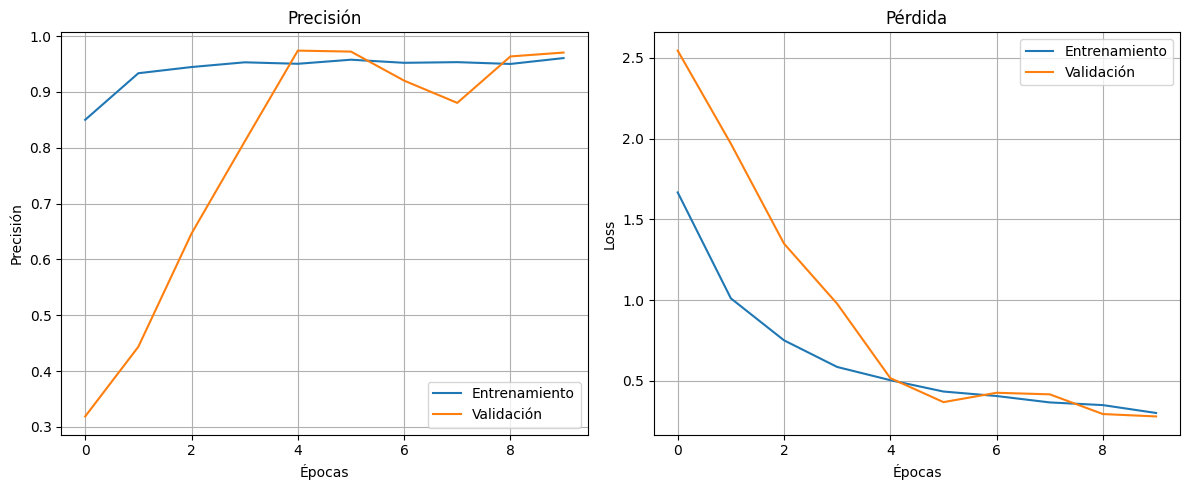

In [48]:
# Precisión
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [49]:
def evaluar_overfitting(history, umbral_acc_diff=0.05, umbral_loss_diff=0.2):
    """
    Evalúa si hay overfitting basándose en la diferencia entre entrenamiento y validación.
    
    Parámetros:
    - history: objeto retornado por model.fit()
    - umbral_acc_diff: diferencia máxima aceptable entre train y val accuracy
    - umbral_loss_diff: diferencia mínima preocupante entre val y train loss
    
    Retorna:
    - str: 'NO overfitting', 'POTENCIAL overfitting', o 'OVERFITTING'
    """
    acc_train = history.history['accuracy'][-1]
    acc_val = history.history['val_accuracy'][-1]
    loss_train = history.history['loss'][-1]
    loss_val = history.history['val_loss'][-1]
    
    acc_diff = acc_train - acc_val
    loss_diff = loss_val - loss_train
    
    if acc_diff < umbral_acc_diff and loss_diff < umbral_loss_diff:
        return 'NO overfitting'
    elif acc_diff < umbral_acc_diff * 2 and loss_diff < umbral_loss_diff * 2:
        return 'POTENCIAL overfitting'
    else:
        return 'OVERFITTING'


In [50]:
resultado = evaluar_overfitting(history)
print(f"Evaluación de overfitting: {resultado}")


Evaluación de overfitting: NO overfitting


In [51]:
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = history.history['val_accuracy'][best_epoch]
print(f"Mejor época: {best_epoch+1}, Precisión de validación: {best_val_acc*100:.2f}%")


Mejor época: 5, Precisión de validación: 97.40%


In [52]:
# Hacer una predicción con datos de entrada nuevos
predictions = model.predict(X_test)

# Convertir las predicciones de vuelta a la clase (el índice con la mayor probabilidad)
predicted_classes = np.argmax(predictions, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [53]:
# Evaluar en el conjunto de testeo
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"Pérdida en el conjunto de testeo: {test_loss:.4f}")
print(f"Precisión en el conjunto de testeo: {test_accuracy:.4f}")

19/19 - 0s - 8ms/step - accuracy: 0.9740 - loss: 0.5167
Pérdida en el conjunto de testeo: 0.5167
Precisión en el conjunto de testeo: 0.9740


In [54]:
# Generar predicciones
predicciones = model.predict(X_test)
print(predicciones)
# Si es clasificación, convertir las probabilidades a etiquetas
y_pred = np.argmax(predicciones, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[0.02937976 0.8711278  0.05249405 0.00175742 0.01177316 0.03346789]
 [0.00645713 0.00367872 0.00450535 0.9589574  0.01362279 0.01277859]
 [0.00309302 0.00270488 0.00105147 0.01018189 0.87183917 0.11112965]
 ...
 [0.85001403 0.0914723  0.01744051 0.02647296 0.00761684 0.00698339]
 [0.00662575 0.00885603 0.0022119  0.3027389  0.5680297  0.11153766]
 [0.83287346 0.106056   0.01569242 0.02794182 0.00901026 0.0084261 ]]


In [55]:
# Predicciones
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test=np.argmax(y_test, axis=1)
cm=confusion_matrix(y_test, y_pred)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


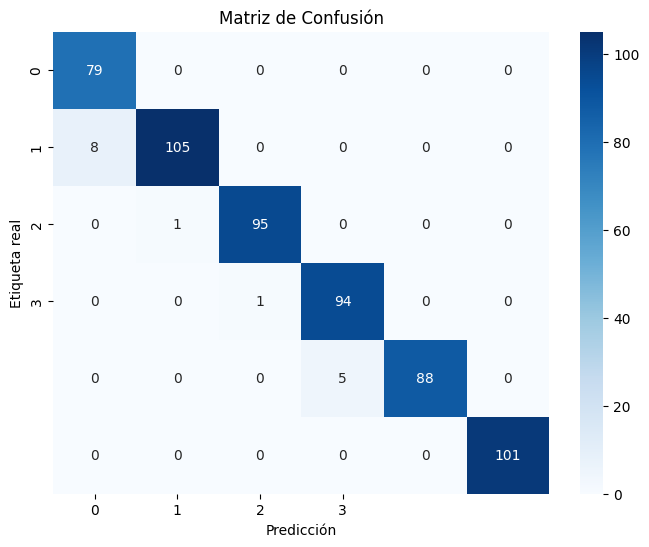

In [56]:
# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de Confusión")
plt.show()

In [27]:
# Guardar el modelo
#model.save('C:/Users/protesis/myoarm/RepoPyoMyo/pyomyo/DatasetExtractV2/modelo_LSTM.keras')